# Master Data Analytics - Tensorflow Assignement 

## Classifing images from Fashion-MNIST 

Student: **Federico Chiricotto**


For this work, similarly to what has been done in class with the MNIST dataset, I decided to tackle the problem of image classification by examining the fashion-MNIST image dataset.

The aim of the project is to train a model capable of classifying the images of the dataset. To do this, I used the tensorflow libraries using the high-level API.
The training phase was carried out in a reasonable time on my own PC using CPU.

In [1]:

#dependencies
import tensorflow as tf
import numpy as np
import pandas as pd

tf.compat.v1.enable_eager_execution()
# tf.compat.v1.disable_eager_execution()

from sklearn.metrics import ConfusionMatrixDisplay, confusion_matrix
from sklearn.metrics import classification_report

import matplotlib.pyplot as plt
import seaborn as sns
import plotly.graph_objs as go
from plotly.subplots import make_subplots
from plotly.offline import init_notebook_mode, iplot
from PIL import Image

print(tf.__version__)
tf.config.get_visible_devices()

device_name = tf.test.gpu_device_name()

if device_name != '/device:GPU:0':

  raise SystemError('GPU device not found')

print('Found GPU at: {}'.format(device_name))

2.9.2
Found GPU at: /device:GPU:0


## Dataset

This assignement uses the [Fashion MNIST](https://github.com/zalandoresearch/fashion-mnist) dataset which contains 70,000 grayscale images in 10 categories. The images show individual articles of clothing at low resolution (28 by 28 pixels)

Fashion MNIST is intended as a drop-in replacement for the classic MNIST dataset—often used as the "Hello, World" of machine learning programs for computer vision. The MNIST dataset contains images of handwritten digits (0, 1, 2, etc.) in a format identical to that of the articles of clothing.

Here, 60,000 images are used to train the network and 10,000 images to evaluate how accurately the network learned to classify images. We can access the Fashion MNIST directly from TensorFlow. 

Import and [load the Fashion MNIST data](https://www.tensorflow.org/api_docs/python/tf/keras/datasets/fashion_mnist/load_data) directly from TensorFlow:

In [2]:
fashion_mnist = tf.keras.datasets.fashion_mnist
(train_images, train_labels), (test_images, test_labels) = fashion_mnist.load_data()

4422102/4422102 [==============================] - 0s 0us/step


Loading the dataset returns four NumPy arrays:

* The `train_images` and `train_labels` arrays are the *training set*—the data the model uses to learn.
* The model is tested against the *test set*, the `test_images`, and `test_labels` arrays.

The images are 28x28 NumPy arrays, with pixel values ranging from 0 to 255. 

The *labels* are an array of integers, ranging from 0 to 9. 
These correspond to the *class* of clothing the image represents:

<table>
  <tr>
    <th>Label</th>
    <th>Class</th>
  </tr>
  <tr>
    <td>0</td>
    <td>T-shirt/top</td>
  </tr>
  <tr>
    <td>1</td>
    <td>Trouser</td>
  </tr>
    <tr>
    <td>2</td>
    <td>Pullover</td>
  </tr>
    <tr>
    <td>3</td>
    <td>Dress</td>
  </tr>
    <tr>
    <td>4</td>
    <td>Coat</td>
  </tr>
    <tr>
    <td>5</td>
    <td>Sandal</td>
  </tr>
    <tr>
    <td>6</td>
    <td>Shirt</td>
  </tr>
    <tr>
    <td>7</td>
    <td>Sneaker</td>
  </tr>
    <tr>
    <td>8</td>
    <td>Bag</td>
  </tr>
    <tr>
    <td>9</td>
    <td>Ankle boot</td>
  </tr>
</table>

Since the *class names* are not included with the dataset, store them here to use later when plotting the images. Each image is mapped to a single label.

In [3]:
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat', 'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']
class_names

['T-shirt/top',
 'Trouser',
 'Pullover',
 'Dress',
 'Coat',
 'Sandal',
 'Shirt',
 'Sneaker',
 'Bag',
 'Ankle boot']

## EDA: Exploratory Data Analysis

Let's explore the format of the dataset before training the model. The following shows there are 60,000 images in the training set and 10,000 images in the test set. 
Each image is represented as 28 x 28 pixels:

In [4]:
print("train-shape: {} - test-shape: {}".format(train_images.shape, test_images.shape))

train-shape: (60000, 28, 28) - test-shape: (10000, 28, 28)


Likewise, there are 60,000 labels in the training set and 10,000 labels in the test set:

In [5]:
print("train-samples: {} - test-samples: {}".format(len(train_labels), len(test_labels)))

train-samples: 60000 - test-samples: 10000


Each label is an integer between 0 and 9:

In [6]:
print("train-labels: {}".format(np.unique(train_labels)))
print("test-labels: {}".format(np.unique(test_labels)))

train-labels: [0 1 2 3 4 5 6 7 8 9]
test-labels: [0 1 2 3 4 5 6 7 8 9]


Here an example of images from the Fashion-MNIST dataset

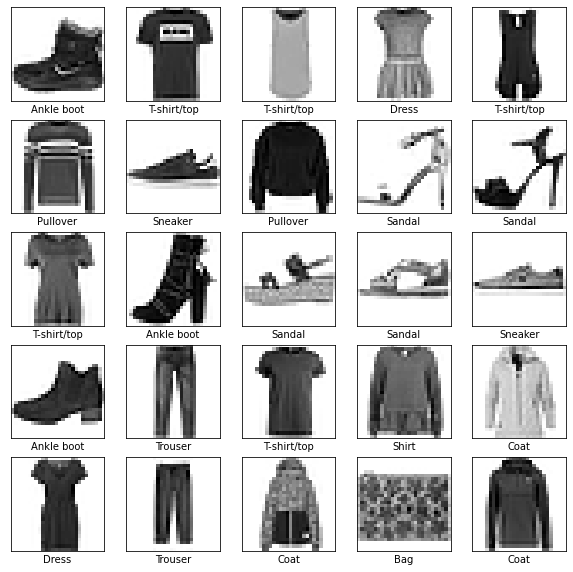

In [7]:
plt.figure(figsize=(10,10))
for i in range(25):
    plt.subplot(5,5,i+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[i], cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[i]])
plt.show()


Let's see how many number of images are in each class. We start with the train set.

### Train set images class distribution

In [8]:
# Create a dictionary for each type of label 

labels = { index : i for index, i in enumerate(class_names) }
labels

{0: 'T-shirt/top',
 1: 'Trouser',
 2: 'Pullover',
 3: 'Dress',
 4: 'Coat',
 5: 'Sandal',
 6: 'Shirt',
 7: 'Sneaker',
 8: 'Bag',
 9: 'Ankle boot'}

In [9]:
def get_classes_distribution(data_labels) -> pd.DataFrame:
    total_samples = len(data_labels)
    unique, counts = np.unique(data_labels, return_counts=True)
    total_labels = len(unique)
    percentage = counts / total_samples *100

    #create df for plot
    df = pd.DataFrame(columns=['id', 'labels', 'count'])
    for i in range(total_labels):
        df.loc[i] =  [unique[i]] + [labels[i]] + [counts[i]]
        print("{:<20s}:   {} or {}%".format(labels[i], counts[i], percentage[i]))

    return df


In [10]:
df_label_train = get_classes_distribution(train_labels)

T-shirt/top         :   6000 or 10.0%
Trouser             :   6000 or 10.0%
Pullover            :   6000 or 10.0%
Dress               :   6000 or 10.0%
Coat                :   6000 or 10.0%
Sandal              :   6000 or 10.0%
Shirt               :   6000 or 10.0%
Sneaker             :   6000 or 10.0%
Bag                 :   6000 or 10.0%
Ankle boot          :   6000 or 10.0%


The classes are equaly distributed in the train set (10% each). Let's check the same for the test set. 

In [11]:
df_label_test = get_classes_distribution(test_labels)

T-shirt/top         :   1000 or 10.0%
Trouser             :   1000 or 10.0%
Pullover            :   1000 or 10.0%
Dress               :   1000 or 10.0%
Coat                :   1000 or 10.0%
Sandal              :   1000 or 10.0%
Shirt               :   1000 or 10.0%
Sneaker             :   1000 or 10.0%
Bag                 :   1000 or 10.0%
Ankle boot          :   1000 or 10.0%


The classes are equaly distributed in the test set (10% each)

Let's also plot the class distribution.

In [12]:
# def plot_class_distribution(df_label: pd.DataFrame, title:str) -> None:
#     f, ax = plt.subplots(1,1, figsize=(10,4))
#     ax = sns.barplot(df_label, x="labels", y="count")
#     ax.set_title("Number of labels for each class - {}".format(title))
#     plt.show()  

In [13]:
# plot_class_distribution(df_label_train, "train set")

In [14]:
# plot_class_distribution(df_label_test, "test set")

## Preprocessing

<Figure size 432x288 with 0 Axes>

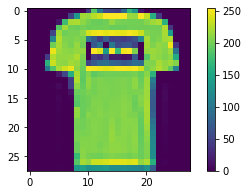

In [15]:
plt.figure()
plt.figure(figsize=(6,3))
plt.imshow(train_images[1])
plt.colorbar()
plt.grid(False)
plt.show()

First of all we need to scale these values to a range of 0 to 1 before feeding them to the neural network model. 

To do so, divide the values by 255. It's important that the *training set* and the *testing set* be preprocessed in the same way:

In [16]:
# Normalize the input data.
def scale(image, label):
  image = tf.cast(image, tf.float32)
  image /= 255.0
  return image, label

train_images, train_labels = scale(train_images, train_labels)
test_images, test_labels = scale(test_images, test_labels)

## Build Model

Building the neural network requires configuring the layers of the model, then compiling the model.

### Set up the layers

The basic building block of a neural network is the **layer**. Layers extract representations from the data fed into them. Hopefully, these representations are meaningful for the problem at hand.

Most of deep learning consists of chaining together simple layers. Most layers, such as `tf.keras.layers.Dense`, have parameters that are learned during training.

I will use a **Sequential** model, a linear stack of layers. 

In this first model the layers added are as follows:
 
- **Flatten**. It transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). Think of this layer as unstacking rows of pixels in the image and lining them up. This layer has no parameters to learn; it only reformats the data.
- **Dense**. This layer is a regular fully-connected NN layer. It is used with the parameters:
  - units - this is a positive integer, with the meaning: dimensionality of the output space; in this case is: 128;
  - activation - activation function : `relu`
- **Dense**. This is the final layer (fully connected). It is used with the parameters: 
  - units: the number of classes (in our case 10);
  - activation : `softmax`; for this final layer it is used `softmax` activation (standard for multiclass classification) It converts the model's linear outputs—logits to probabilities, which should be easier to interpret. Each node contains a probability that indicates the current image belongs to one of the 10 classes. 

In [17]:
#TENSOR_EXAMPLE
model = tf.keras.Sequential([
    tf.keras.layers.Flatten(input_shape=(28, 28,1)),
    tf.keras.layers.Dense(128, activation='relu'),
    tf.keras.layers.Dense(10, activation="softmax")
])

In [18]:
model.summary()

Model: "sequential"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 flatten (Flatten)           (None, 784)               0         
                                                                 
 dense (Dense)               (None, 128)               100480    
                                                                 
 dense_1 (Dense)             (None, 10)                1290      
                                                                 
Total params: 101,770
Trainable params: 101,770
Non-trainable params: 0
_________________________________________________________________


### Compile the model

Before the model is ready for training, it needs a few more settings. These are added during the model's **compile** step which onfigures the model for training.

- **Loss function**: measures how accurate the model is during training. We want to minimize this function to "steer" the model in the right direction.
- **Optimizer**: how the model is updated based on the data it sees and its loss function.
- **Metrics**: Used to monitor the training and testing steps. Here I'll use *accuracy*, the fraction of the images that are correctly classified.

In [19]:
model.compile(
    optimizer='adam',
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=['accuracy']
    )

## Training

Training the neural network model requires the following steps:

1. Feed the training data to the model: `train_images` and `train_labels` arrays.
2. Model learns to associate images and labels.
3. Make predictions about a test set: `test_images` array.
4. Verify that the predictions match the labels from the `test_labels` array.

### Feed the model

First of all I defined the callbacks; Callbacks can be passed to keras methods such as fit, evaluate, and predict in order to hook into the various stages of the model training and inference lifecycle.

In [20]:
# callbacks
ourcallbacks = [
    tf.keras.callbacks.ModelCheckpoint(
        filepath='./models/MNIST/model.{epoch:02d}-{loss:.2f}.h5',
        save_best_only=True
        ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/MNIST/')
]

In [21]:
%load_ext tensorboard

To start training,  call the `model.fit` method; it "fits" the model to the training data.
In order to fit the model I'm going to use the following parameters:
- **x**: training images;
- **y**: training images target labels;
- **batch_size**: Number of samples per gradient update;
- **epochs**: number of epochs to train the model. An epoch is an iteration over the entire x and y data provided;
- **validation_data**: data on which to evaluate the loss and any model metrics at the end of each epoch. The model will not be trained on this data; 
- **callbacks**: list of callbacks to apply during training. 

In [22]:
history = model.fit(
    train_images, 
    train_labels,
    batch_size=4096, 
    epochs=75,
    verbose=1,
    validation_data=(test_images, test_labels),
    callbacks=ourcallbacks
    )


Epoch 1/75
15/15 [==============================] - 4s 54ms/step - loss: 1.4452 - accuracy: 0.5370 - val_loss: 0.8758 - val_accuracy: 0.7039
Epoch 2/75
15/15 [==============================] - 0s 20ms/step - loss: 0.7431 - accuracy: 0.7430 - val_loss: 0.6740 - val_accuracy: 0.7665
Epoch 3/75
15/15 [==============================] - 0s 20ms/step - loss: 0.6071 - accuracy: 0.7960 - val_loss: 0.5903 - val_accuracy: 0.8028
Epoch 4/75
15/15 [==============================] - 0s 22ms/step - loss: 0.5440 - accuracy: 0.8184 - val_loss: 0.5464 - val_accuracy: 0.8144
Epoch 5/75
15/15 [==============================] - 0s 22ms/step - loss: 0.5082 - accuracy: 0.8295 - val_loss: 0.5239 - val_accuracy: 0.8195
Epoch 6/75
15/15 [==============================] - 0s 29ms/step - loss: 0.4854 - accuracy: 0.8359 - val_loss: 0.5038 - val_accuracy: 0.8290
Epoch 7/75
15/15 [==============================] - 0s 18ms/step - loss: 0.4674 - accuracy: 0.8414 - val_loss: 0.4902 - val_accuracy: 0.8321
Epoch 8/75
15

As the model trains, the loss and accuracy metrics are displayed. This simple model reaches an accuracy of about 0.88 (or $\sim$ 88%) on the training data.

### Evaluate accuracy

Here I want to show how the model performs on the test dataset. Here I'm going to call the `model.evaluate` method, which returns the loss value & metrics values for the model in test mode, with the following parameters:
- **x**: Input data (test images)
- **y**: Target data (test labels)
- **verbose**: 2 = single line

In [23]:
test_loss, test_acc = model.evaluate(
    test_images,  
    test_labels, 
    verbose=2
    )

print('\nTest accuracy:', test_acc)
print('Test loss:', test_loss)

313/313 - 1s - loss: 0.3352 - accuracy: 0.8797 - 571ms/epoch - 2ms/step

Test accuracy: 0.8797000050544739
Test loss: 0.3351559042930603


#### Accuracy and Loss graphs

Let us plot the Training and Validation Accuracy & Loss to get a better understanding of the model training.

In [24]:
init_notebook_mode(connected=True)

def create_trace(x,y,ylabel,color):
        trace = go.Scatter(
            x = x,y = y,
            name=ylabel,
            marker=dict(color=color),
            mode = "markers+lines",
            text=x
        )
        return trace
    
def plot_accuracy_and_loss(history, accuracy:str):
    hist = history.history
    acc = hist[accuracy]
    val_acc = hist['val_'+ accuracy]
    loss = hist['loss']
    val_loss = hist['val_loss']
    epochs = list(range(1,len(acc)+1))
    
    trace_ta = create_trace(epochs,acc,"Training accuracy", "Green")
    trace_va = create_trace(epochs,val_acc,"Validation accuracy", "Red")
    trace_tl = create_trace(epochs,loss,"Training loss", "Blue")
    trace_vl = create_trace(epochs,val_loss,"Validation loss", "Magenta")
    fig = make_subplots(rows=1,cols=2, subplot_titles=('Training and validation accuracy', 'Training and validation loss'))
    fig.append_trace(trace_ta,1,1)
    fig.append_trace(trace_va,1,1)
    fig.append_trace(trace_tl,1,2)
    fig.append_trace(trace_vl,1,2)
    fig['layout']['xaxis'].update(title = 'Epoch')
    fig['layout']['xaxis2'].update(title = 'Epoch')
    fig['layout']['yaxis'].update(title = 'Accuracy', range=[0,1])
    fig['layout']['yaxis2'].update(title = 'Loss', range=[0,1])

    
    iplot(fig, filename='accuracy-loss')

In [25]:
plot_accuracy_and_loss(history, "accuracy")

The validation accuracy does not improve after around 50 epochs and the validation loss is decreasing very slowly. The model, albeit simple, does not seem to show overfitting phenomena. As expected, the accuracy of the test data is lower than the training one but they are still close.

Later, I will try to improve the model by adding layers. 

### Confusion Matrix


`math.confusion_matrix` module computes the confusion matrix from predictions and labels. The matrix columns represent the prediction labels and the rows represent the real labels.

In [26]:
predictions = model.predict(test_images)
pred_labels = np.argmax(predictions, axis=1)

cm = tf.math.confusion_matrix(
    test_labels,
    pred_labels,
    num_classes=10,
)

cm

313/313 [==============================] - 1s 1ms/step


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[826,   2,  16,  33,   5,   1, 108,   1,   8,   0],
       [  6, 964,   0,  24,   3,   0,   3,   0,   0,   0],
       [ 12,   0, 799,  14, 102,   0,  72,   0,   1,   0],
       [ 21,   9,  18, 893,  33,   0,  21,   0,   5,   0],
       [  0,   1,  94,  31, 819,   0,  52,   0,   3,   0],
       [  1,   0,   0,   1,   0, 955,   0,  25,   1,  17],
       [120,   3,  97,  32,  69,   0, 669,   0,  10,   0],
       [  0,   0,   0,   0,   0,  22,   0, 948,   0,  30],
       [  3,   0,   7,   6,   7,   1,   6,   4, 966,   0],
       [  0,   0,   0,   0,   0,   8,   1,  33,   0, 958]], dtype=int32)>

#### Plot confusion matrix with sklearn

In order to make the results more readable, I'm going to plot the confusion matrix:

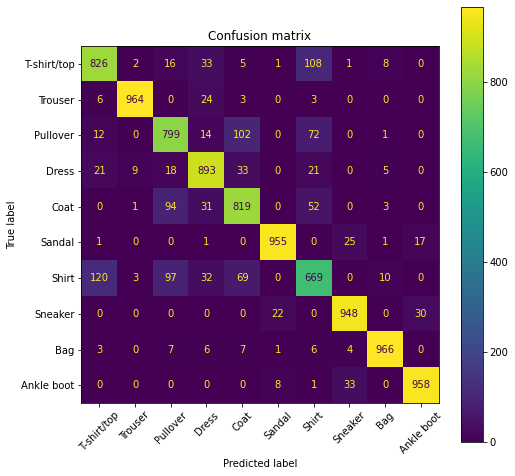

In [27]:
plt.rcParams["figure.figsize"] = (8,8)

cm = confusion_matrix(test_labels, pred_labels)
disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
disp.plot()
plt.title("Confusion matrix")
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.show()

Looking at the confusion matrix it is clear that the greatest number of prediction errors are committed in the categories shirt, t-shirt, coat and pullover. These are articles of clothing that are very similar to each other and therefore more difficult to classify.

In [28]:
print(classification_report(test_labels, pred_labels, target_names = class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.84      0.83      0.83      1000
     Trouser       0.98      0.96      0.97      1000
    Pullover       0.77      0.80      0.79      1000
       Dress       0.86      0.89      0.88      1000
        Coat       0.79      0.82      0.80      1000
      Sandal       0.97      0.95      0.96      1000
       Shirt       0.72      0.67      0.69      1000
     Sneaker       0.94      0.95      0.94      1000
         Bag       0.97      0.97      0.97      1000
  Ankle boot       0.95      0.96      0.96      1000

    accuracy                           0.88     10000
   macro avg       0.88      0.88      0.88     10000
weighted avg       0.88      0.88      0.88     10000



In the table I'm showing the following scores:
- **precision** is the ability of the classifier not to label as positive a sample that is negative: $$tp / (tp + fp)$$ where $tp$ is the number of true positives and $fp$ the number of false positives.  
- **recall** is the ability of the classifier to find all the positive samples: $$tp / (tp + fn)$$ where $tp$ is the number of true positives and $fn$ the number of false negatives.
- **f1-score**, also known as balanced F-score or F-measure, can be interpreted as a harmonic mean of the precision and recall $$f1 = 2 * (precision * recall) / (precision + recall)$$

Looking at the classification report we observe that, in accordance with what has been said about the confusion matrix, the classes with a lower score are shirt, pullover, tshirt and coat.

## Predict
### Make predictions

With the model trained, we can use it to make predictions about images.

In [29]:
predictions = model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


Here, the model has predicted the label for each image in the testing set. Let's take a look at the first prediction:

In [30]:
predictions[0]

array([1.0712971e-05, 2.8590514e-07, 4.3215596e-06, 3.2614545e-07,
       2.5760462e-06, 8.7786773e-03, 2.1835918e-05, 1.5414892e-02,
       2.4939294e-04, 9.7551697e-01], dtype=float32)

A prediction is an array of 10 numbers. They represent the model's "confidence" that the image corresponds to each of the 10 different articles of clothing. 

We can see which label has the highest confidence value:

In [31]:
np.argmax(predictions[0])

9

So, the model is most confident that this image is an ankle boot, or `class_names[9]`. Examining the test label shows that this classification is correct:

In [32]:
test_labels[0]

9

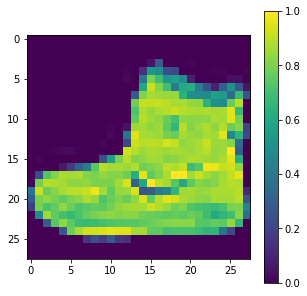

In [33]:
plt.figure(figsize=(5,5))
plt.imshow(train_images[0])
plt.colorbar()
plt.grid(False)
plt.show()

### Verify predictions

Let's look at some images, predictions, and prediction array. Correct prediction labels are blue and incorrect prediction labels are red. The number gives the percentage (out of 100) for the predicted label.

In [34]:
def plot_image(i, predictions_array, true_label, img):
    true_label, img = true_label[i], img[i]
    plt.grid(False)
    plt.xticks([])
    plt.yticks([])

    plt.imshow(img, cmap=plt.cm.binary)

    predicted_label = np.argmax(predictions_array)
    if predicted_label == true_label:
        color = 'blue'
    else:
        color = 'red'

    plt.xlabel("{} {:2.0f}% ({})".format(class_names[predicted_label],
                                100*np.max(predictions_array),
                                class_names[true_label]),
                                color=color)

def plot_value_array(i, predictions_array, true_label):
    true_label = true_label[i]
    plt.grid(False)
    plt.xticks(range(10))
    plt.yticks([])
    thisplot = plt.bar(range(10), predictions_array, color="#777777")
    plt.ylim([0, 1])
    predicted_label = np.argmax(predictions_array)

    thisplot[predicted_label].set_color('red')
    thisplot[true_label].set_color('blue')

Lets plot some test examples

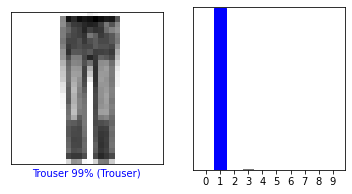

In [35]:
i = 15
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

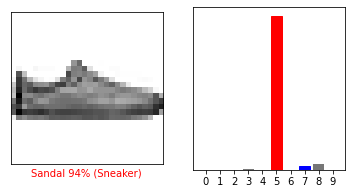

In [36]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions[i],  test_labels)
plt.show()

Let's plot several images with their predictions. Note that the model can be wrong even when very confident.

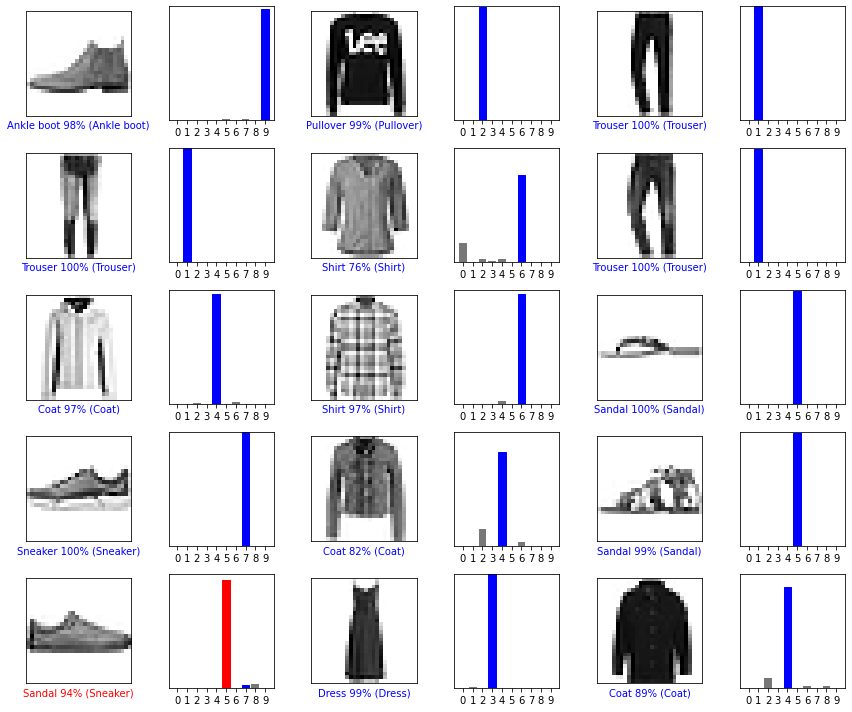

In [37]:
# Plot the first 15 test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 5
num_cols = 3
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions[i], test_labels)
plt.tight_layout()
plt.show()

# Try to improve model 

In order to try to improve the model I'm going to add the layers added are as follows:

- **Conv2D**: it is a 2D Convolutional layer. The parameters used are:
  - filters - the number of filters (Kernels) used with this layer; here filters = 32;
  - kernel_size - the dimmension of the Kernel: (3 x 3);
  - activation - is the activation function used, in this case `relu`;
  - kernel_initializer - the function used for initializing the kernel;
  - input_shape - is the shape of the image presented to the CNN: in our case is 28 x 28
- **MaxPooling2D**: is a pooling operation that calculates the maximum value for patches of a feature map, and uses it to create a downsampled (pooled) feature map. It is usually used after a convolutional layer. Parameters used here are:
  - *pool_size*, in this case (2,2), representing the factors by which to downscale in both directions;
- **Dropout**: randomly selected neurons are ignored during training. They are “dropped out” randomly. This means that their contribution to the activation of downstream neurons is temporally removed on the forward pass, and any weight updates are not applied to the neuron on the backward pass. The effect is that the network becomes less sensitive to the specific weights of neurons. This results in a network capable of better generalization and less likely to overfit the training data.  
- **Conv2D**: with the following parameters:
  - filters: 64;
  - kernel_size : (3 x 3);
  - activation : `relu`;
- **MaxPooling2D**: is a Max pooling operation with parameter:
  - *pool_size* : (2,2);
- **Dropout**:The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time. 
- **Flatten**: it transforms the format of the images from a two-dimensional array (of 28 by 28 pixels) to a one-dimensional array (of 28 * 28 = 784 pixels). 
- **Dense**: this layer is a regular fully-connected NN layer.
  - units : 32;
  - activation : `relu`
- **Dropout**: The Dropout layer randomly sets input units to 0 with a frequency of rate at each step during training time. 
- **Dense**: this is the final layer (fully connected). 
  - units: the number of classes (10);
  - activation : `softmax`;

In [38]:

model_upgrade = tf.keras.models.Sequential([
    tf.keras.layers.Conv2D(32, 3, activation='relu', input_shape=(28, 28, 1)),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2, ),

    tf.keras.layers.Conv2D(64, 3, activation='relu'),
    tf.keras.layers.MaxPooling2D(),
    tf.keras.layers.Dropout(0.2),

    tf.keras.layers.Flatten(),
    tf.keras.layers.Dense(32,activation='relu'),
    tf.keras.layers.Dropout(0.3),
    tf.keras.layers.Dense(10, activation="softmax")
    ]) 


In [39]:
model_upgrade.summary()

Model: "sequential_1"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 conv2d (Conv2D)             (None, 26, 26, 32)        320       
                                                                 
 max_pooling2d (MaxPooling2D  (None, 13, 13, 32)       0         
 )                                                               
                                                                 
 dropout (Dropout)           (None, 13, 13, 32)        0         
                                                                 
 conv2d_1 (Conv2D)           (None, 11, 11, 64)        18496     
                                                                 
 max_pooling2d_1 (MaxPooling  (None, 5, 5, 64)         0         
 2D)                                                             
                                                                 
 dropout_1 (Dropout)         (None, 5, 5, 64)         

In [40]:
# #OPTIONS
model_upgrade.compile(
    optimizer=tf.keras.optimizers.Adam(0.001),
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    metrics=["accuracy"],
)

# #OPTIONS
# model_upgrade.compile(
#     optimizer=tf.keras.optimizers.Adam(0.001),
#     loss=tf.keras.losses.SparseCategoricalCrossentropy(from_logits=True),
#     metrics=[tf.keras.metrics.SparseCategoricalAccuracy()],
# )

In [41]:
# callbacks
ourcallbacks = [
    # tf.keras.callbacks.ModelCheckpoint(
    #     filepath='./models/MNIST2/model_upgrade.{epoch:02d}-{loss:.2f}.h5',
    #     save_best_only=True
    #     ),
    tf.keras.callbacks.TensorBoard(log_dir='./logs/FINAL/')
]

In [42]:
%reload_ext tensorboard

In [43]:
history_upgrade = model_upgrade.fit(
    train_images, 
    train_labels,
    batch_size=128, 
    epochs=100, 
    verbose=1,
    validation_data=(test_images, test_labels),
    callbacks=ourcallbacks
    )

Epoch 1/100
469/469 [==============================] - 9s 6ms/step - loss: 0.8113 - accuracy: 0.7073 - val_loss: 0.4799 - val_accuracy: 0.8248
Epoch 2/100
469/469 [==============================] - 3s 5ms/step - loss: 0.5474 - accuracy: 0.8008 - val_loss: 0.4179 - val_accuracy: 0.8475
Epoch 3/100
469/469 [==============================] - 3s 6ms/step - loss: 0.4819 - accuracy: 0.8246 - val_loss: 0.3768 - val_accuracy: 0.8638
Epoch 4/100
469/469 [==============================] - 2s 5ms/step - loss: 0.4412 - accuracy: 0.8402 - val_loss: 0.3502 - val_accuracy: 0.8730
Epoch 5/100
469/469 [==============================] - 3s 5ms/step - loss: 0.4186 - accuracy: 0.8483 - val_loss: 0.3358 - val_accuracy: 0.8796
Epoch 6/100
469/469 [==============================] - 2s 5ms/step - loss: 0.3957 - accuracy: 0.8558 - val_loss: 0.3254 - val_accuracy: 0.8823
Epoch 7/100
469/469 [==============================] - 3s 5ms/step - loss: 0.3805 - accuracy: 0.8629 - val_loss: 0.3041 - val_accuracy: 0.8917

As the model trains, the loss and accuracy metrics are displayed. This simple model reaches an accuracy of about 0.92 (or $\sim$ 92%) on the training data.

In [44]:
test_loss_up, test_acc_up = model_upgrade.evaluate(test_images,  test_labels, verbose=2)
print('\nTest accuracy:', test_acc_up)
print('\nTest loss:', test_loss_up)

313/313 - 1s - loss: 0.2465 - accuracy: 0.9121 - 664ms/epoch - 2ms/step

Test accuracy: 0.9121000170707703

Test loss: 0.24654975533485413


In [45]:
plot_accuracy_and_loss(history_upgrade, "accuracy")


The validation accuracy does not improve after around 60 epochs and the validation loss is decreasing very slowly. The model, albeit simple, does not seem to show overfitting phenomena. As expected, the accuracy of the test data is lower than the training one but they are very close. This means that model is working well on unknown data.

### Confusion Matrix

In [46]:
predictions_upgrade = model_upgrade.predict(test_images)

pred_labels_up = np.argmax(predictions_upgrade, axis=1)

cm_up = tf.math.confusion_matrix(
    test_labels,
    pred_labels,
    num_classes=10,
)

cm_up

313/313 [==============================] - 1s 2ms/step


<tf.Tensor: shape=(10, 10), dtype=int32, numpy=
array([[826,   2,  16,  33,   5,   1, 108,   1,   8,   0],
       [  6, 964,   0,  24,   3,   0,   3,   0,   0,   0],
       [ 12,   0, 799,  14, 102,   0,  72,   0,   1,   0],
       [ 21,   9,  18, 893,  33,   0,  21,   0,   5,   0],
       [  0,   1,  94,  31, 819,   0,  52,   0,   3,   0],
       [  1,   0,   0,   1,   0, 955,   0,  25,   1,  17],
       [120,   3,  97,  32,  69,   0, 669,   0,  10,   0],
       [  0,   0,   0,   0,   0,  22,   0, 948,   0,  30],
       [  3,   0,   7,   6,   7,   1,   6,   4, 966,   0],
       [  0,   0,   0,   0,   0,   8,   1,  33,   0, 958]], dtype=int32)>

#### Plot confusion matrix

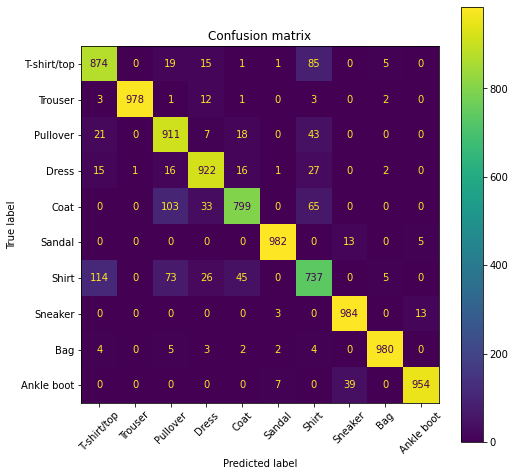

In [47]:
plt.rcParams["figure.figsize"] = (8,8)

cm_up = confusion_matrix(test_labels, pred_labels_up)
disp = ConfusionMatrixDisplay(confusion_matrix=cm_up, display_labels=class_names)
disp.plot()
plt.title("Confusion matrix")
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names, rotation=45)
plt.yticks(tick_marks, class_names)
plt.show()

Looking at the confusion matrix it is clear that the greatest number of prediction errors are again committed in the categories shirt, t-shirt, coat and pullover. These are articles of clothing that are very similar to each other and therefore more difficult to classify. 

Despite this, the model seems to have better performance than the previous one and makes fewer mistakes.

In [48]:
print(classification_report(test_labels, pred_labels_up, target_names = class_names))

              precision    recall  f1-score   support

 T-shirt/top       0.85      0.87      0.86      1000
     Trouser       1.00      0.98      0.99      1000
    Pullover       0.81      0.91      0.86      1000
       Dress       0.91      0.92      0.91      1000
        Coat       0.91      0.80      0.85      1000
      Sandal       0.99      0.98      0.98      1000
       Shirt       0.76      0.74      0.75      1000
     Sneaker       0.95      0.98      0.97      1000
         Bag       0.99      0.98      0.98      1000
  Ankle boot       0.98      0.95      0.97      1000

    accuracy                           0.91     10000
   macro avg       0.91      0.91      0.91     10000
weighted avg       0.91      0.91      0.91     10000



Looking at the classification report we observe that, in accordance with what has been said about the confusion matrix, the classes with a lower score are shirt, pullover, tshirt and coat.

Compared to the previous case, which is reported below, the respective scores have slightly improved. 

<table>
  <tr>
    <th>Class</th>
    <th>precision</th>
    <th>recall</th>
    <th>f1-score</th>
  </tr>
  <tr>
    <td>T-shirt/top</td>
    <td>0.88 </td>
    <td>0.73</td>
    <td>0.80 </td>
  </tr>
  <tr>
    <td>Pullover</td>
    <td>0.78</td>
    <td>0.80</td>
    <td>0.79</td>
  </tr>
  <tr>
    <td>Coat</td>
    <td>0.80</td>
    <td>0.79</td>
    <td>0.80</td>
  </tr>
  <tr>
    <td>Shirt</td>
    <td>0.67</td>
    <td>0.71</td>
    <td>0.69</td>
  </tr>
</table>



Let's plot several images with their predictions.

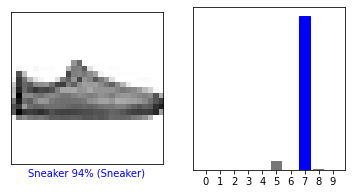

In [49]:
i = 12
plt.figure(figsize=(6,3))
plt.subplot(1,2,1)
plot_image(i, predictions_upgrade[i], test_labels, test_images)
plt.subplot(1,2,2)
plot_value_array(i, predictions_upgrade[i],  test_labels)
plt.show()

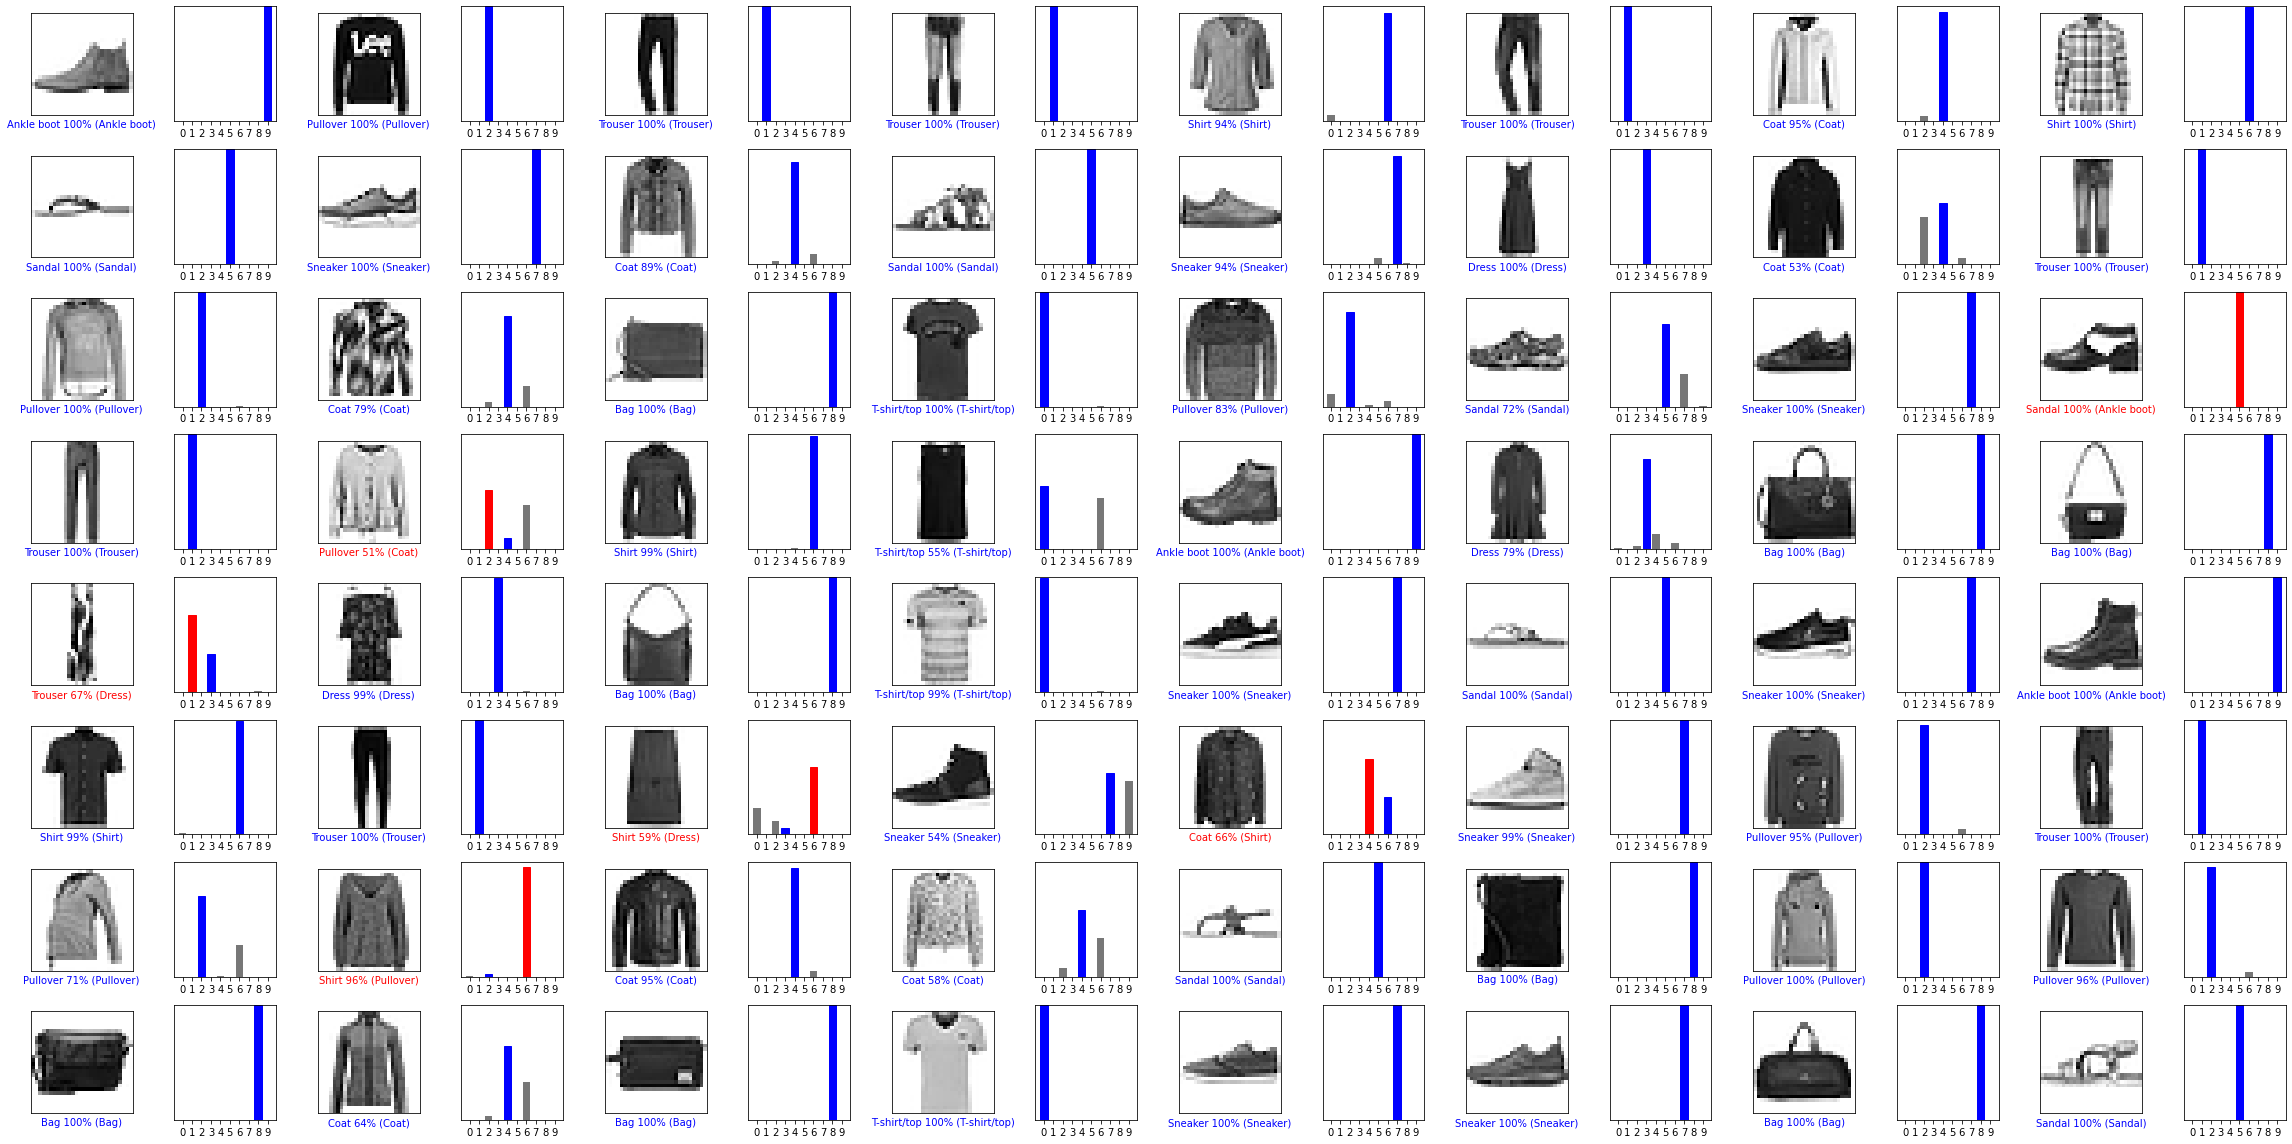

In [68]:
# Plot the first X test images, their predicted labels, and the true labels.
# Color correct predictions in blue and incorrect predictions in red.
num_rows = 8
num_cols = 8
num_images = num_rows*num_cols
plt.figure(figsize=(2*2*num_cols, 2*num_rows))
for i in range(num_images):
  plt.subplot(num_rows, 2*num_cols, 2*i+1)
  plot_image(i, predictions_upgrade[i], test_labels, test_images)
  plt.subplot(num_rows, 2*num_cols, 2*i+2)
  plot_value_array(i, predictions_upgrade[i], test_labels)
plt.tight_layout()
plt.show()

In [51]:
!pip install shap

Looking in indexes: https://pypi.org/simple, https://us-python.pkg.dev/colab-wheels/public/simple/
     |████████████████████████████████| 575 kB 7.4 MB/s 


In [52]:

# !pip install shap
import shap
import numpy as np

num_classes = 10
img_rows, img_cols = 28, 28

(x_train, y_train), (x_test, y_test) = fashion_mnist.load_data()

if tf.keras.backend.image_data_format() == 'channels_first':
    x_train = x_train.reshape(x_train.shape[0], 1, img_rows, img_cols)
    x_test = x_test.reshape(x_test.shape[0], 1, img_rows, img_cols)
    input_shape = (1, img_rows, img_cols)
else:
    x_train = x_train.reshape(x_train.shape[0], img_rows, img_cols, 1)
    x_test = x_test.reshape(x_test.shape[0], img_rows, img_cols, 1)
    input_shape = (img_rows, img_cols, 1)

# x_train = x_train.reshape(x_train.shape[0], 28, 28, 1)
# x_test = x_test.reshape(x_test.shape[0], 28, 28, 1)

x_train = x_train.astype('float32')
x_test = x_test.astype('float32')
x_train /= 255
x_test /= 255
print('x_train shape:', x_train.shape)
print(x_train.shape[0], 'train samples')
print(x_test.shape[0], 'test samples')

# convert class vectors to binary class matrices
y_train = tf.keras.utils.to_categorical(y_train, num_classes)
y_test = tf.keras.utils.to_categorical(y_test, num_classes)


# from tensorflow.python.ops.numpy_ops import np_config

# np_config.enable_numpy_behavior()




# tf.config.run_functions_eagerly(True)
# tf.compat.v1.disable_v2_behavior() # run this if you get tensor related error

# select a set of background examples to take an expectation over
background = x_train[np.random.choice(x_train.shape[0], 100, replace=False)]



x_train shape: (60000, 28, 28, 1)
60000 train samples
10000 test samples


In [53]:
# explain predictions of the model on three images
e = shap.DeepExplainer(model, background)


keras is no longer supported, please use tf.keras instead.
Your TensorFlow version is newer than 2.4.0 and so graph support has been removed in eager mode and some static graphs may not be supported. See PR #1483 for discussion.


In [54]:
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[1:5])

`tf.keras.backend.set_learning_phase` is deprecated and will be removed after 2020-10-11. To update it, simply pass a True/False value to the `training` argument of the `__call__` method of your layer or model.


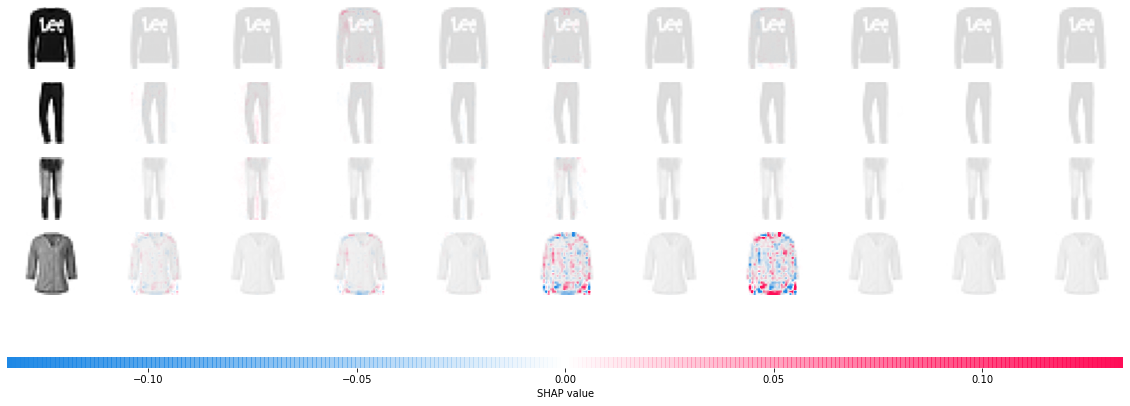

In [55]:
# plot the feature attributions
shap.image_plot(shap_values, -x_test[1:5])

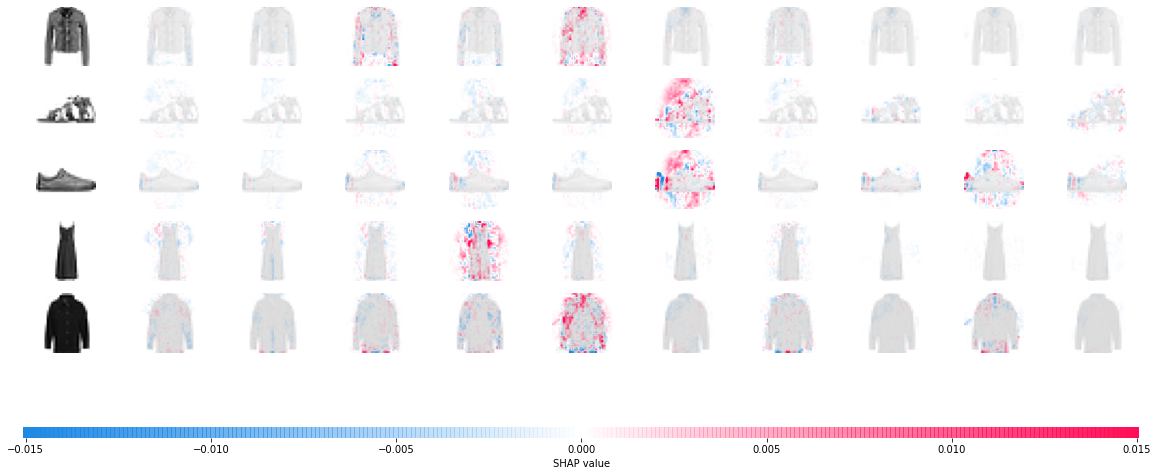

In [56]:
# ...or pass tensors directly
# e = shap.DeepExplainer((model.layers[0].input, model.layers[-1].output), background)
shap_values = e.shap_values(x_test[10:15])
# plot the feature attributions
shap.image_plot(shap_values, -x_test[10:15])

MODEL UPGRADED

In [57]:
# explain predictions of the model on three images
new = shap.DeepExplainer(model_upgrade, background)

In [65]:
# ...or pass tensors directly
shap_values_new = new.shap_values(x_test[[0,1,2,4,6,8,9,13,18,19]])

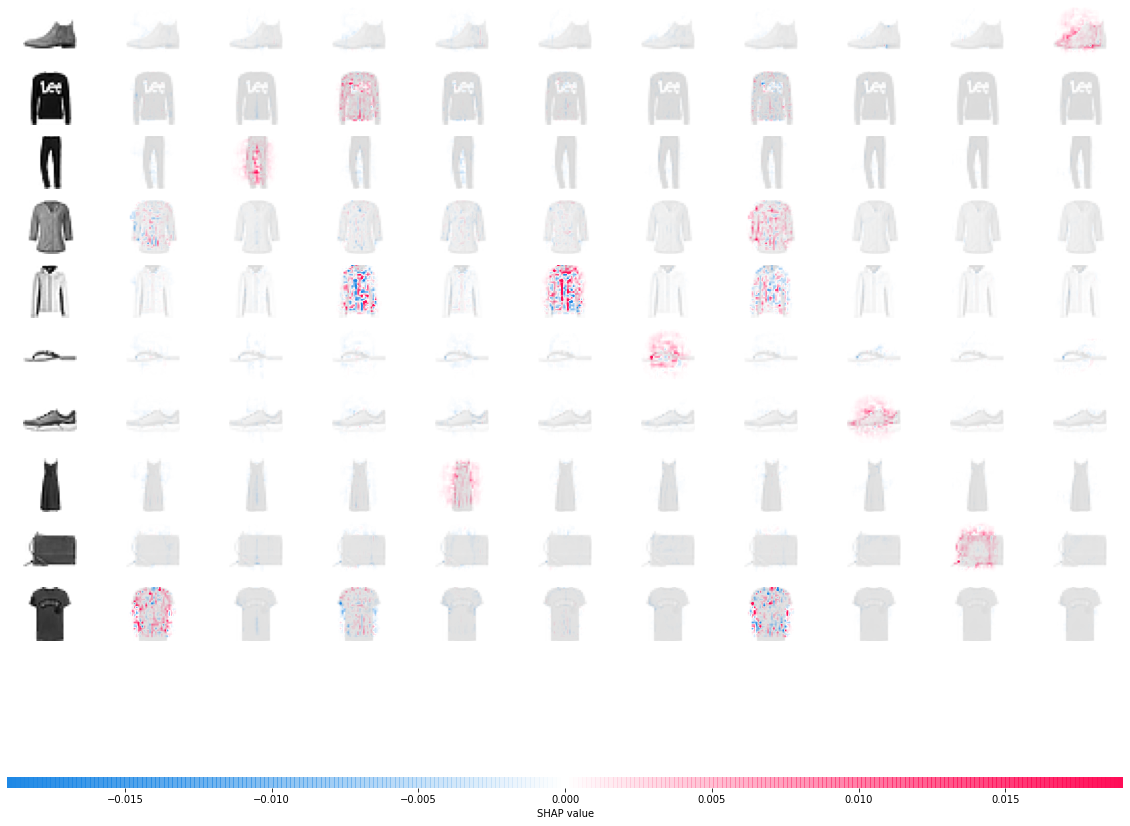

In [66]:
# plot the feature attributions
shap.image_plot(shap_values_new, -x_test[[0,1,2,4,6,8,9,13,18,19]])

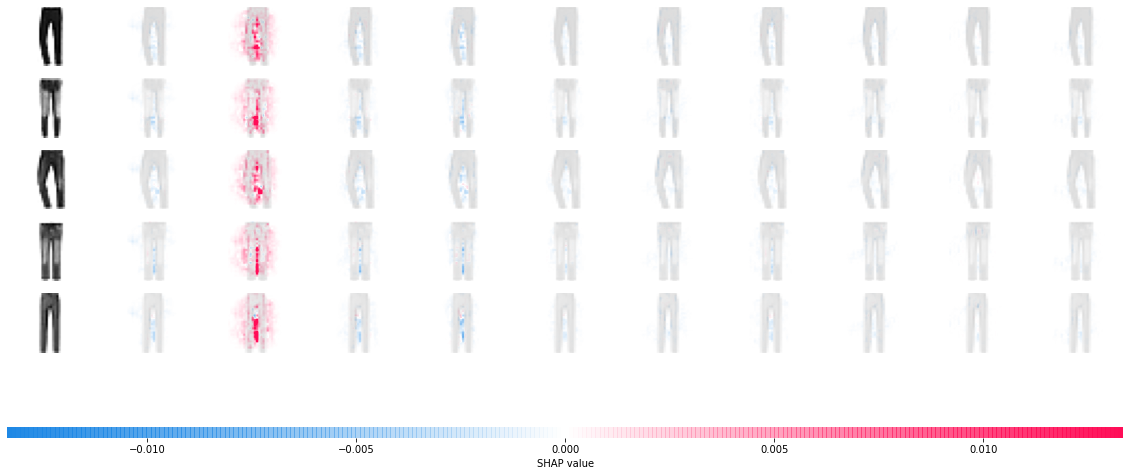

In [67]:
# ...or pass tensors directly
shap_values_new = new.shap_values(x_test[[2,3,5,15,24]])

# plot the feature attributions
shap.image_plot(shap_values_new, -x_test[[2,3,5,15,24]])

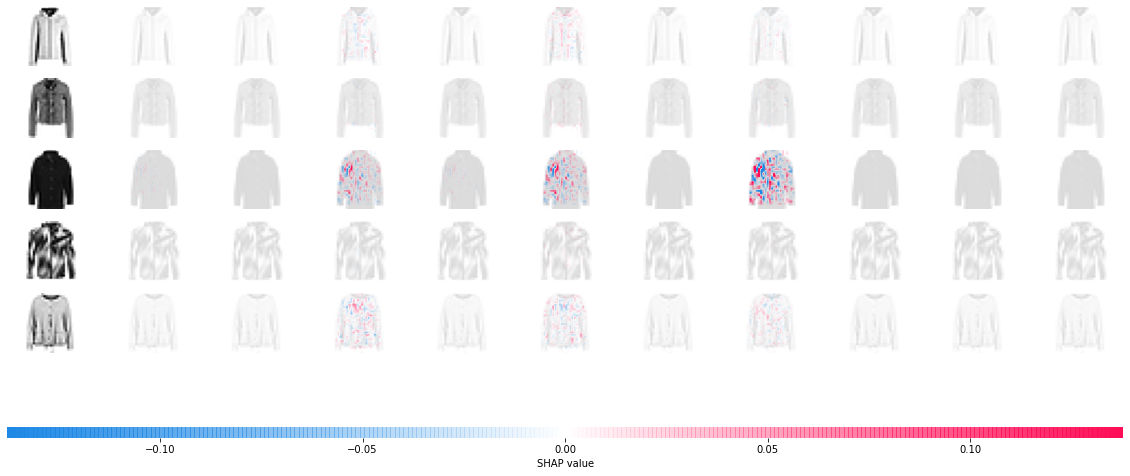

In [69]:
# ...or pass tensors directly
shap_values_new = new.shap_values(x_test[[6,10,14,17,25]])

# plot the feature attributions
shap.image_plot(shap_values_new, -x_test[[6,10,14,17,25]])